### Importing Necessary Packages

In [425]:
import random
import pandas as pd
import numpy as np
import re
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer('distilbert-base-nli-mean-tokens')

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from wordcloud import WordCloud

### Extracting Research Paper Data From XML files

In [426]:
import xml.etree.ElementTree as ET

xml_file_path = "/Users/sindhuswaroop/Documents/NEU/Semester 4/NLP/Project/scisummnet_release1.1__20190413/top1000_complete/W99-0629/Documents_xml/W99-0629.xml"
#xml_file_path = "/Users/sindhuswaroop/Documents/NEU/Semester 4/NLP/Project/scisummnet_release1.1__20190413/top1000_complete/W99-0623/Documents_xml/W99-0623.xml"
tree = ET.parse(xml_file_path)
root = tree.getroot()

# Function to extract all text data from the XML tree
def extract_text_data(element):
    # Some data cleaning steps
    text = (element.text or "").strip()
    text_data = text.lower()
    text_data = text_data.replace("quot", "")
    text_data = re.sub(r'https?://\S+', '', text_data) 
    text_data = re.sub(r'[^\w\s]', '', text_data)
    
    for child in element:
        text_data = np.append(text_data, extract_text_data(child))
    
    return text_data

# Extract all data as a list of sentences
all_data_text = list(extract_text_data(root))

In [427]:
# Remove any empty quotes from the list that have been generated as a result of whitespaces
corpus_init = [item for item in all_data_text if item != '']
# Remove the title of the paper from the corpus
corpus = corpus_init[1:]

### Create Sentence Embeddings

In [428]:
# Use the distilbert model to create sentence embeddings
corpus_embeddings = embedder.encode(corpus)
corpus_embeddings

array([[-1.012199  ,  0.17508511,  0.17485283, ..., -0.22337137,
        -0.47548178, -0.08711005],
       [-0.678853  , -0.34683377,  0.41877174, ..., -0.1500783 ,
        -0.30285347,  0.08025892],
       [-0.24281536,  0.04788744,  0.22654526, ..., -0.4888069 ,
        -0.23782721, -0.2504147 ],
       ...,
       [-0.6477107 ,  0.07216249,  0.28515923, ...,  0.09160032,
        -0.20706658,  0.2806898 ],
       [ 0.27915314,  0.20080784,  0.7615137 , ...,  0.09984943,
        -0.41873354, -1.0703954 ],
       [-0.5795836 , -0.10806998,  0.01855101, ..., -0.37602288,
         0.09338623, -0.5323497 ]], dtype=float32)

### Elbow Method To Choose Optimum K-value 

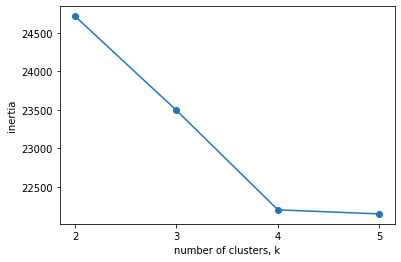

In [429]:
np.random.seed(60)

ks = range(2, 6)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, n_init='auto')
    # Fit model to samples
    model.fit(corpus_embeddings)
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

Inertia decreases slowly from clusters 4 to 5, so 4 clusters looks like the best option

In [430]:
np.random.seed(60)

# Use the K-means clustering algorithm to create clusters of sentences that are grouped by similarity
num_clusters = 4
clustering_model = KMeans(n_clusters=num_clusters, n_init='auto')
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_
clusterCenter = clustering_model.cluster_centers_

In [431]:
cluster_assignment

array([2, 2, 2, 1, 0, 2, 0, 0, 0, 2, 1, 2, 3, 3, 3, 1, 2, 2, 1, 0, 3, 1,
       3, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 1, 3, 0, 1, 2, 0, 1, 1, 1, 2, 2,
       1, 3, 2, 3, 3, 2, 2, 2, 1, 1, 1, 2, 0, 3, 1, 2, 1, 1, 1, 2, 2, 2,
       2, 3, 1, 2, 3, 3, 1, 2, 2, 0, 1, 2, 2, 0, 1, 3, 3, 3, 2, 3, 1, 3,
       2, 1, 3, 1, 3, 2, 3, 0, 3, 3, 0, 3, 3, 3, 1, 3, 3, 1, 1, 1, 3, 3,
       1, 2, 1, 3, 0, 2, 3, 2, 1, 0, 1, 2, 0, 2, 2, 2, 1, 3, 2, 3, 2, 3,
       2, 0, 0, 3, 2, 2, 2, 1, 2, 3, 2, 1, 3, 3, 3, 3, 3, 2, 1, 0, 1, 3,
       0, 3, 0, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 2, 0, 1, 2, 1, 1, 3, 1,
       0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 3], dtype=int32)

In [432]:
# Create a data frame to view the clustering of each sentence in the corpus
cluster_df = pd.DataFrame(corpus, columns = ['corpus'])
cluster_df['cluster'] = cluster_assignment
cluster_df.head(10)

,corpus,cluster
0,in this paper we discuss cascaded memory based...,2
1,in the first stages of the cascade we find chu...,2
2,in the last stage we assign grammatical relati...,2
3,we studied the effect of adding several levels...,1
4,when dealing with large amounts of text findin...,0
5,traditionally full parsing is used to find str...,2
6,however full parsing is a complex task and oft...,0
7,for many tasks detecting only shallow structur...,0
8,for example in information retrieval it can be...,0
9,in this paper we discuss some memorybased mb s...,2


### Visualize K-means clusters in 2-D

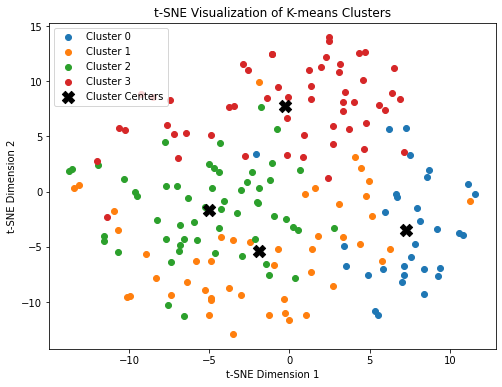

In [433]:
# Create a t-SNE object with 2 components (2D visualization)
tsne = TSNE(n_components=2, random_state=42)

# clusterCenterFit the t-SNE on your data (corpus_embeddings)
embeddings_2d = tsne.fit_transform(corpus_embeddings)
cluster_centers_2d = np.zeros((num_clusters, 2))

# Plot the data points with different colors based on their cluster assignments
plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    plt.scatter(embeddings_2d[cluster_assignment == i, 0],
                embeddings_2d[cluster_assignment == i, 1],
                label=f"Cluster {i}")
    cluster_centers_2d[i] = np.mean(embeddings_2d[cluster_assignment == i], axis=0)

# Plot the cluster centers with black 'X' markers
plt.scatter(cluster_centers_2d[:, 0], cluster_centers_2d[:, 1],
            marker='X', s=150, color='black', label='Cluster Centers')

plt.legend()
plt.title("t-SNE Visualization of K-means Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

### Display Clusters 

In [434]:
# Display the sentences grouped under each cluster and 
# generate the text summary by picking the first sentence in each cluster
clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(corpus[sentence_id])
most_important_sentence = ""
summary = ""
for i, cluster in enumerate(clustered_sentences):
    print("\nCluster ", i+1)
    print(cluster)
    most_important_sentence = cluster[0][:1].upper() + cluster[0][1:]
    summary += most_important_sentence + ". "


Cluster  1
['when dealing with large amounts of text finding structure in sentences is often a useful preprocessing step', 'however full parsing is a complex task and often provides us with more information then we need', 'for many tasks detecting only shallow structures in a sentence in a fast and reliable way is to be preferred over full parsing', 'for example in information retrieval it can be enough to find only simple nps and vps in a sentence for information extraction we might also want to find relations between constituents as for example the subject and object of a verb', 'collins 1997 ratnaparkhi 1997 use cascaded processing for full parsing with good results', 'through experiments with cascading several classifiers we will show that even using imperfect classifiers can improve overall performance of the cascaded classifier', 'since not all of these entities are predicted reliably it is the question whether each source leads to an improvement of the overall gr assignment', '

### Generate Text Summary

In [435]:
print(corpus_init[0][:1].upper()+corpus_init[0][1:], "\n\nText Summary:", summary)

Cascaded grammatical relation assignment 

Text Summary: When dealing with large amounts of text finding structure in sentences is often a useful preprocessing step. We studied the effect of adding several levels to this cascaded classifier and we found that even the less performing chunkers enhanced the performance of the relation finder. In this paper we discuss cascaded memory based grammatical relations assignment. What is the effect of cascading. 


### Evaluate Text Summary

In [436]:
# Import necessary packages
from rouge_score import rouge_scorer

In [437]:
# reference_summaries = ["Three state-of-the-art statistical parsers are combined to produce more accurate parses, \
# as well as new bounds on achievable Treebank parsing accuracy. Two general approaches are presented and two combination \
# techniques are described for each approach. Both parametric and non-parametric models are explored. The resulting parsers \
# surpass the best previously published performance results for the Penn Treebank. We improve the best parser's F-measure of \
# 89.7 to 91.3, using naive Bayes voting on the Penn TreeBank constituent structures (16% error reduction). Regarding the \
# system combination study, we propose two parser combination schemes, one that selects an entire tree from one of the parsers, \
# and one that builds a new tree by selecting constituents suggested by the initial trees. We perform parse selection by \
# maximizing the expected precision of the selected parse with respectto the set of parses being combined."]

reference_summaries = ["In this paper we discuss cascaded Memory-Based grammatical relations assignment. In the first stages \
of the cascade, we find chunks of several types (NP,VP,ADJP,ADVP,PP) and label them with their adverbial function (e.g. local, \
temporal).In the last stage, we assign grammatical relations to pairs of chunks. We studied the effect of adding several \
levels to this cascaded classifier and we found that even the less performing chunkers enhanced the performance of the \
relation finder. We achieve 71.2 F-score for grammatical relation assignment on automatically tagged and chunked text after \
training on about 40,000 Wall Street Journal sentences."]

generated_summaries = [summary]

In [438]:
# Use Rouge score technique to evaluate text summary
rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

for i, (reference_summary, summary) in enumerate(zip(reference_summaries, generated_summaries)):
    scores = rouge_scorer.score(reference_summary, summary)
    print(f"ROUGE scores for generated summary {i+1}:")
    print("ROUGE-1 Precision:", scores['rouge1'].precision)
    print("ROUGE-1 Recall:", scores['rouge1'].recall)
    print("ROUGE-1 F1-Score:", scores['rouge1'].fmeasure)
    print("ROUGE-2 Precision:", scores['rouge2'].precision)
    print("ROUGE-2 Recall:", scores['rouge2'].recall)
    print("ROUGE-2 F1-Score:", scores['rouge2'].fmeasure)
    print("ROUGE-L Precision:", scores['rougeL'].precision)
    print("ROUGE-L Recall:", scores['rougeL'].recall)
    print("ROUGE-L F1-Score:", scores['rougeL'].fmeasure)
    print("---------------------")

ROUGE scores for generated summary 1:
ROUGE-1 Precision: 0.7741935483870968
ROUGE-1 Recall: 0.4528301886792453
ROUGE-1 F1-Score: 0.5714285714285714
ROUGE-2 Precision: 0.6065573770491803
ROUGE-2 Recall: 0.3523809523809524
ROUGE-2 F1-Score: 0.4457831325301205
ROUGE-L Precision: 0.5645161290322581
ROUGE-L Recall: 0.330188679245283
ROUGE-L F1-Score: 0.4166666666666667
---------------------


* Rouge-1 F1-score of 0.57 indicates 57% of unigram overlap between the reference summary and generated summary
* Rouge-2 F1-score of 0.44 indicates 44% of bigram overlap between the reference summary and generated summary
* Rouge-L F1-score of 0.41 indicates 41% overlap of longest common word-sequence between the reference summary and generated summary

Rouge scores of 0.5 are considered excellent results considering how two summaries can be written differently.